<a href="https://colab.research.google.com/github/yenlung/Deep-Learning-Basics/blob/master/colab02c%20%E7%94%A8%E9%81%B7%E7%A7%BB%E5%AD%B8%E7%BF%92%E6%89%93%E9%80%A0%E5%85%AB%E5%93%A5%E8%BE%A8%E8%AD%98AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

台灣最常見的八哥有 (土) 八哥、白尾八哥及家八哥三種。我們來挑戰每種八哥只用三張照片, 看能不能打造一個神經網路學會辨識這三種八哥。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. 讀入八哥資料圖檔

這裡把我在 GitHub 上存成 `pickle` 的八哥圖檔讀進來, 這已經是變成 `numpy array` 格式的。

In [2]:
from urllib.request import urlretrieve
import pickle

In [3]:
urlretrieve("https://github.com/yenlung/Deep-Learning-Basics/raw/master/data/myna/myna_input.pickle", "myna_input.pickle")
urlretrieve("https://github.com/yenlung/Deep-Learning-Basics/raw/master/data/myna/myna_output.pickle", "myna_output.pickle")

('myna_output.pickle', <http.client.HTTPMessage at 0x7f45b625f2d0>)

In [4]:
f = open('myna_input.pickle', 'rb')
data = pickle.load(f)
f.close()

In [5]:
f = open('myna_output.pickle', 'rb')
target = pickle.load(f)
f.close()

看看 `data` 的 `shape`, 我們確定只有 9 張照片, 大小是 256x256。


In [6]:
data.shape

(9, 256, 256, 3)

答案就是三種八哥, 依次為白尾八哥、家八哥、(土)八哥。

In [7]:
target

array([1, 1, 1, 2, 2, 2, 3, 3, 3])

### 2. 整理輸入和輸出資料

輸出的部份我們要做 one-hot encoding, 輸入要注意每個名門 CNN model 都有他們自己慣用的預處理。 

In [8]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input

我們選張八哥圖來看看。

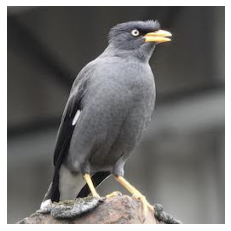

In [9]:
n=1
plt.axis('off')
plt.imshow(data[n]);

看來沒有什麼意外, 就是個鳥圖。我們用 ResNet 的預處理再看一次。

In [10]:
x_train = preprocess_input(data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


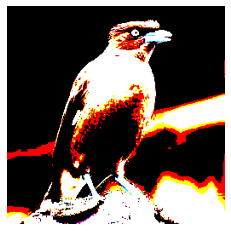

In [11]:
plt.axis('off')
plt.imshow(x_train[n]);

這看來好像八哥都要變猛禽了啊! 反正 ResNet 覺得這樣對它比較容易。

一個答案就是 1, 2, 3 其中一個數字。

In [12]:
target[n]

1

要注意要做 one-hot encoding, 我們需要改為 0, 1, 2。

In [13]:
y_train = to_categorical(target-1, 3)

In [14]:
y_train[n]

array([1., 0., 0.], dtype=float32)

### 3. 用 ResNet50 打造我們的神經網路

ResNet50 是 2015 ImageNet 的冠軍, 我們用第二版來試試。原本 ImageNet 是做了 1,000 個類別的圖形辨識。我們想直接用來辨識八哥, 就是把最後一層 (通常就 1,000 個輸出的 dense 層) 砍掉 (`include_top=False`), 然後換我們的就好。

再來我們可以把每個 filter 的結果做個大總合, 例如算每個 filter 計分板的總平均 (global avg pooling), 這本來該我們自己做, 但是 `tf.Keras` 是善良無比的幫我們做好。只要下個參數 `pooling="avg"`)。

In [15]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [16]:
resnet = ResNet50V2(include_top=False, pooling="avg")

我們是遷移式學習, 原本 ResNet 的部份我們當然沒有重新訓練的意思。於是就設這邊不需要訓練。

In [17]:
resnet.trainable = False

再來就是正式打造我們遷移學習版的函數學習機! 可以發現我們只是加入了最後一層...

In [18]:
model = Sequential()

In [19]:
model.add(resnet)

In [20]:
model.add(Dense(3, activation='softmax'))

#### 組裝我們的函數學習機

這裡我們用分類時非常標準的 `categorical_crossentropy`, 順便試試有名的 `adam` 學習法。

In [21]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

#### 欣賞我們的神經網路

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,570,947
Trainable params: 6,147
Non-trainable params: 23,564,800
_________________________________________________________________


我們可以發現原來有超過兩千萬個參數, 經我們偷來, 不是, 借來以後, 只有 6,147 個參數要調。

### 4. 訓練 fit

這裡我們全部的資料也只有 9 筆, 所以 `batch_size` 就選擇 9 了...

In [24]:
model.fit(x_train, y_train, batch_size=9, epochs=25)

Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 60.9538 - accuracy: 0.4444
Epoch 2/25
1/1 [==============================] - 0s 35ms/step - loss: 42.7042 - accuracy: 0.4444
Epoch 3/25
1/1 [==============================] - 0s 35ms/step - loss: 81.0572 - accuracy: 0.4444
Epoch 4/25
1/1 [==============================] - 0s 35ms/step - loss: 67.3922 - accuracy: 0.4444
Epoch 5/25
1/1 [==============================] - 0s 36ms/step - loss: 26.6100 - accuracy: 0.4444
Epoch 6/25
1/1 [==============================] - 0s 35ms/step - loss: 24.4233 - accuracy: 0.3333
Epoch 7/25
1/1 [==============================] - 0s 35ms/step - loss: 41.9118 - accuracy: 0.5556
Epoch 8/25
1/1 [==============================] - 0s 35ms/step - loss: 44.6770 - accuracy: 0.4444
Epoch 9/25
1/1 [==============================] - 0s 36ms/step - loss: 38.3570 - accuracy: 0.3333
Epoch 10/25
1/1 [==============================] - 0s 36ms/step - loss: 31.8872 - accuracy: 0.4444
Epoch 11/25
1/1 [====

### 5. 預測

對了, 為何這次我們沒有切測試一一資料呢? 那是因為畢竟我們每張八哥只有 3 張照片。我們可以看一下訓練成果。

In [27]:
y_predict = np.argmax(model.predict(x_train), -1)

In [28]:
y_predict

array([0, 0, 0, 1, 1, 0, 2, 2, 2])

好奇的話比較一下正確答案。

In [29]:
target-1

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

#### 三種八哥的 `labels`

In [30]:
labels=["白尾八哥", "家八哥", "(土)八哥"]

### 6. 用 `gradio` 打造八哥辨識 web app!

In [31]:
!pip install gradio

In [32]:
import gradio as gr

注意現在主函數和我們做辨識 Cooper 的例子很像, 只是現在我們只有三個種類。而且是我們的 `model`!

In [36]:
def classify_image(inp):
  inp = inp.reshape((-1, 256, 256, 3))
  inp = preprocess_input(inp)
  prediction = model.predict(inp).flatten()
  return {labels[i]: float(prediction[i]) for i in range(3)}

image = gr.inputs.Image(shape=(256, 256), label="八哥照片")
label = gr.outputs.Label(num_top_classes=3, label="AI辨識結果")

In [38]:
gr.Interface(fn=classify_image, inputs=image, outputs=label,
             title="AI 八哥辨識機",
             description="我能辨識台灣常見的三種八哥: (土)八哥、家八哥、白尾八哥。快找張八哥照片來考我吧!",
             capture_session=True).launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://52261.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7861/',
 'https://52261.gradio.app')